# Imports

In [1]:
import os

# Set current working directory to parent folder
os.chdir(os.path.abspath(".."))

In [2]:
import pandas as pd
import json

# Archivos importantes y paths
df_annotations = pd.read_excel('data/annotations.xlsx')

# Omitimos todos los audios en development
df_annotations = df_annotations[df_annotations['Type'] != 'Development'].reset_index(drop = True)

# WhisperTokenizer

In [3]:
from transformers import WhisperTokenizer

# Load the tokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-large")

# Get all tokens
all_tokens = tokenizer.get_vocab()

# Get max value item
max_value = max(zip(all_tokens.values(), all_tokens.keys()))[0]

C:\Users\Emanuel\anaconda3\envs\SER\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
df_texto = pd.DataFrame()

df_texto.loc[0, 'id'] = 0

for file in os.listdir('data/TRANSCRIPCIONES/WHISPER'):
    with open(f'data/TRANSCRIPCIONES/WHISPER/{file}', 'r') as f: 
        data = json.load(f)
    
    start = max(df_texto.index)
    
    for i in range(len(data['segments'])):
        df_texto.at[i + start, 'Audio'] = file[:-5]
        df_texto.at[i + start, 'id'] = int(data['segments'][i]['id'])
        df_texto.at[i + start, 'Text'] = data['segments'][i]['text']
        df_texto.at[i + start, 'Tokens'] = str(data['segments'][i]['tokens'][1:-1])

In [5]:
df_texto.head()

,id,Audio,Text,Tokens
0,0.0,MSP-Conversation_0002,It's our honor to talk about important issues...,"[467, 311, 527, 5968, 281, 751, 466, 1021, 266..."
1,1.0,MSP-Conversation_0002,"The foundation of our show, Heart of the Matt...","[440, 7030, 295, 527, 855, 11, 13569, 295, 264..."
2,2.0,MSP-Conversation_0002,Important issues and why they should be on ou...,"[42908, 2663, 293, 983, 436, 820, 312, 322, 52..."
3,3.0,MSP-Conversation_0002,Looking at things as right versus wrong inste...,"[11053, 412, 721, 382, 558, 5717, 2085, 2602, ..."
4,4.0,MSP-Conversation_0002,And sharing stories with real people's experi...,"[400, 5414, 3676, 365, 957, 561, 311, 5235, 37..."


In [6]:
# Agregamos cantidad de palabras
df_texto['num_words'] = df_texto['Text'].apply(lambda x:len(str(x).split()))

In [7]:
df_texto.head()

,id,Audio,Text,Tokens,num_words
0,0.0,MSP-Conversation_0002,It's our honor to talk about important issues...,"[467, 311, 527, 5968, 281, 751, 466, 1021, 266...",16
1,1.0,MSP-Conversation_0002,"The foundation of our show, Heart of the Matt...","[440, 7030, 295, 527, 855, 11, 13569, 295, 264...",13
2,2.0,MSP-Conversation_0002,Important issues and why they should be on ou...,"[42908, 2663, 293, 983, 436, 820, 312, 322, 52...",11
3,3.0,MSP-Conversation_0002,Looking at things as right versus wrong inste...,"[11053, 412, 721, 382, 558, 5717, 2085, 2602, ...",12
4,4.0,MSP-Conversation_0002,And sharing stories with real people's experi...,"[400, 5414, 3676, 365, 957, 561, 311, 5235, 37...",19


# Distribuciones

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

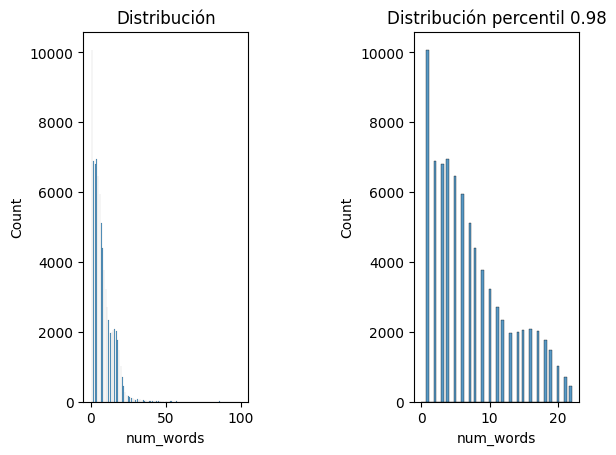

In [9]:
fig, axes = plt.subplots(1, 2)

q = df_texto['num_words'].quantile(0.98)
df_q = df_texto[df_texto['num_words'] <= q]

sns.histplot(df_texto['num_words'], ax=axes[0])
axes[0].set_title('Distribución')

sns.histplot(df_q['num_words'], ax=axes[1])
axes[1].set_title('Distribución percentil 0.98')

fig.subplots_adjust(wspace=1, hspace=5)

plt.show()

# Modelo

## Concatenar objetivos

In [10]:
with open(f'data/MODELS/v1/objetivos.json', 'r') as f: objetivos = json.load(f)

df_objetivos = pd.DataFrame()

for _key in objetivos:
    df_temp = pd.DataFrame({'Audio': _key[:21], 'indice': objetivos[_key]['indice'], 'targets': objetivos[_key]['targets']})
    df_objetivos = pd.concat([df_temp, df_objetivos])

# Just in case para merge
df_texto['id'] = df_texto['id'].astype(int)

df_final = pd.merge(df_texto, df_objetivos, how = 'left', right_on = ['Audio','indice'], left_on = ['Audio','id'])

df_final = df_final.dropna(subset = 'targets')

from src.traductores import obtener_emocion

df_final['Target'] = [obtener_emocion(i[0],i[1],i[2], mapping = 'Ekman') for i in df_final['targets']]

df_final.head()

,id,Audio,Text,Tokens,num_words,indice,targets,Target
402,1,MSP-Conversation_0021,Tommy Mazwai joins me this evening.,"[19448, 28568, 86, 1301, 24397, 385, 341, 5634...",6,1.0,"[22.434153132250582, 25.742998839907195, 27.96...",neutral
403,2,MSP-Conversation_0021,"Tommy Mazwai, who was the day editor at the S...","[19448, 28568, 86, 1301, 11, 567, 390, 264, 78...",10,2.0,"[24.9327970320278, 28.68542406311637, 29.61763...",neutral
404,3,MSP-Conversation_0021,and who started the Soweto business section.,"[293, 567, 1409, 264, 48644, 19515, 1606, 3541...",7,3.0,"[26.283004629131234, 34.07772544586788, 32.202...",joy
405,4,MSP-Conversation_0021,How long ago was that?,"[1012, 938, 2057, 390, 300, 30]",5,4.0,"[27.692511860832894, 31.18817035670357, 30.649...",joy
406,5,MSP-Conversation_0021,It was a year after I'd returned from Harvard.,"[467, 390, 257, 1064, 934, 286, 1116, 8752, 49...",9,5.0,"[16.63573400250941, 12.879463613550815, 12.705...",neutral


## Pre Procesado

### Borramos outliers

In [19]:
q = df_final['num_words'].quantile(0.98)
df_final_outliers = df_final[df_final['num_words'] <= q]
df_final_outliers = df_final_outliers[df_final_outliers['num_words'] > 0]

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def convertir_strarray_a_array(filas):
    x = []
    for fila in filas:
        fila = fila.replace('[','').replace(']','').split(',')
        x.append([int(i) for i in fila])

    return x

df_final_outliers['Tokens'] = convertir_strarray_a_array(df_final_outliers['Tokens'])

In [21]:
df_final_outliers['Audio_Name'] = df_final_outliers['Audio'] + '.wav'

df_final_outliers = pd.merge(df_final_outliers, 
                        df_annotations[['Audio_Name','Type']].drop_duplicates(), 
                        how = 'left', 
                        left_on = 'Audio_Name', 
                        right_on = 'Audio_Name')

### Split

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

x_train = [i for i in df_final_outliers[df_final_outliers['Type'] == 'Train']['Tokens'].values]
x_test = [i for i in df_final_outliers[df_final_outliers['Type'] == 'Test']['Tokens'].values]

x_train = pad_sequences(x_train, padding='post',maxlen = df_final_outliers['num_words'].max())
x_test = pad_sequences(x_test, padding='post',maxlen = df_final_outliers['num_words'].max())

# Encoder de las emociones
Y = df_final_outliers['Target'].values
encoder = OneHotEncoder()
encoder.fit(np.array(Y).reshape(-1,1))

y_train = df_final_outliers[df_final_outliers['Type'] == 'Train']['Target'].values
y_test = df_final_outliers[df_final_outliers['Type'] == 'Test']['Target'].values
y_train = encoder.transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.transform(np.array(y_test).reshape(-1,1)).toarray()

C:\Users\Emanuel\AppData\Local\Temp\ipykernel_15032\669385794.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=categories, y=samples, palette='muted')


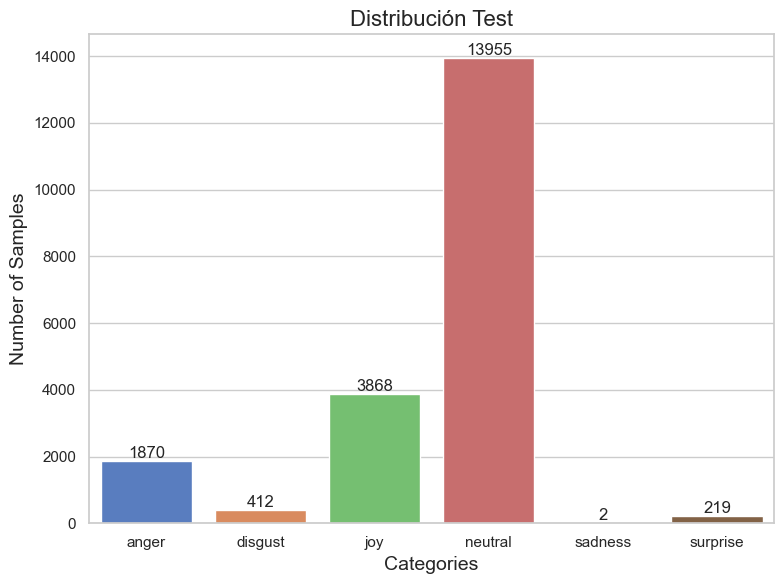

In [59]:
df_aggregated = df_final_outliers[df_final_outliers['Type'] == 'Test'].groupby('Target').count().reset_index()[['Target','id']]

# Sample data
categories = df_aggregated['Target'].values
samples = df_aggregated['id'].values

# Plotting with Seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

# Create barplot
bars = sns.barplot(x=categories, y=samples, palette='muted')

# Adding the counts on top of the bars
for bar, count in zip(bars.patches, samples):
    # Text coordinates (x, y)
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_height()
    # Format the number to display on top of the bar
    text = f'{count}'
    # Display the count
    plt.text(text_x, text_y, text, ha='center', va='bottom', fontsize=12)

# Adding labels and title
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Distribución Test', fontsize=16)

# Show plot
plt.tight_layout()

plt.savefig('barplot.png')
plt.show()

## Entrenamiento

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Embedding, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential()
model.add(Embedding(input_dim = max_value, output_dim=16, input_length=x_train.shape[1]))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=5, min_lr=0.0000001)
es = EarlyStopping(monitor='val_loss', patience=50)
model.fit(x_train, y_train, epochs= 50, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/50
1563/1563 [==============================] - 11s 6ms/step - loss: 1.0146 - accuracy: 0.6654 - val_loss: 1.0152 - val_accuracy: 0.6712
Epoch 2/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9441 - accuracy: 0.6700 - val_loss: 1.0320 - val_accuracy: 0.6555
Epoch 3/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8649 - accuracy: 0.6946 - val_loss: 1.0923 - val_accuracy: 0.6549
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7953 - accuracy: 0.7161 - val_loss: 1.1384 - val_accuracy: 0.6294
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7454 - accuracy: 0.7296 - val_loss: 1.1951 - val_accuracy: 0.6097
Epoch 6/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7081 - accuracy: 0.7397 - val_loss: 1.2463 - val_accuracy: 0.6222
Epoch 7/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6845 - accuracy: 0.7452 - val_loss: 1.3217 - val_accur

In [38]:
model.evaluate(x_test, y_test)

650/650 [==============================] - 0s 596us/step - loss: 6.0470 - accuracy: 0.5468


[6.046952724456787, 0.5467750430107117]

In [100]:
# Requisito ya que tengo predicciones con None
predicciones = encoder.inverse_transform(model.predict(x_test))
realidad = encoder.inverse_transform(y_test)

asd = pd.DataFrame()
asd['Prediccion'] = predicciones[:,0]
asd['Realidad'] = realidad[:,0]

asd = asd[~asd['Prediccion'].isna()]
asd = asd[~asd['Realidad'].isna()]

650/650 [==============================] - 0s 653us/step


In [107]:
pd.concat([asd['Prediccion'],asd['Realidad']]).unique()

array(['neutral', 'joy', 'anger', 'disgust', 'surprise', 'sadness'],
      dtype=object)

In [109]:
encoder.categories_

[array(['anger', 'disgust', 'joy', 'neutral', 'sadness', 'surprise', None],
       dtype=object)]

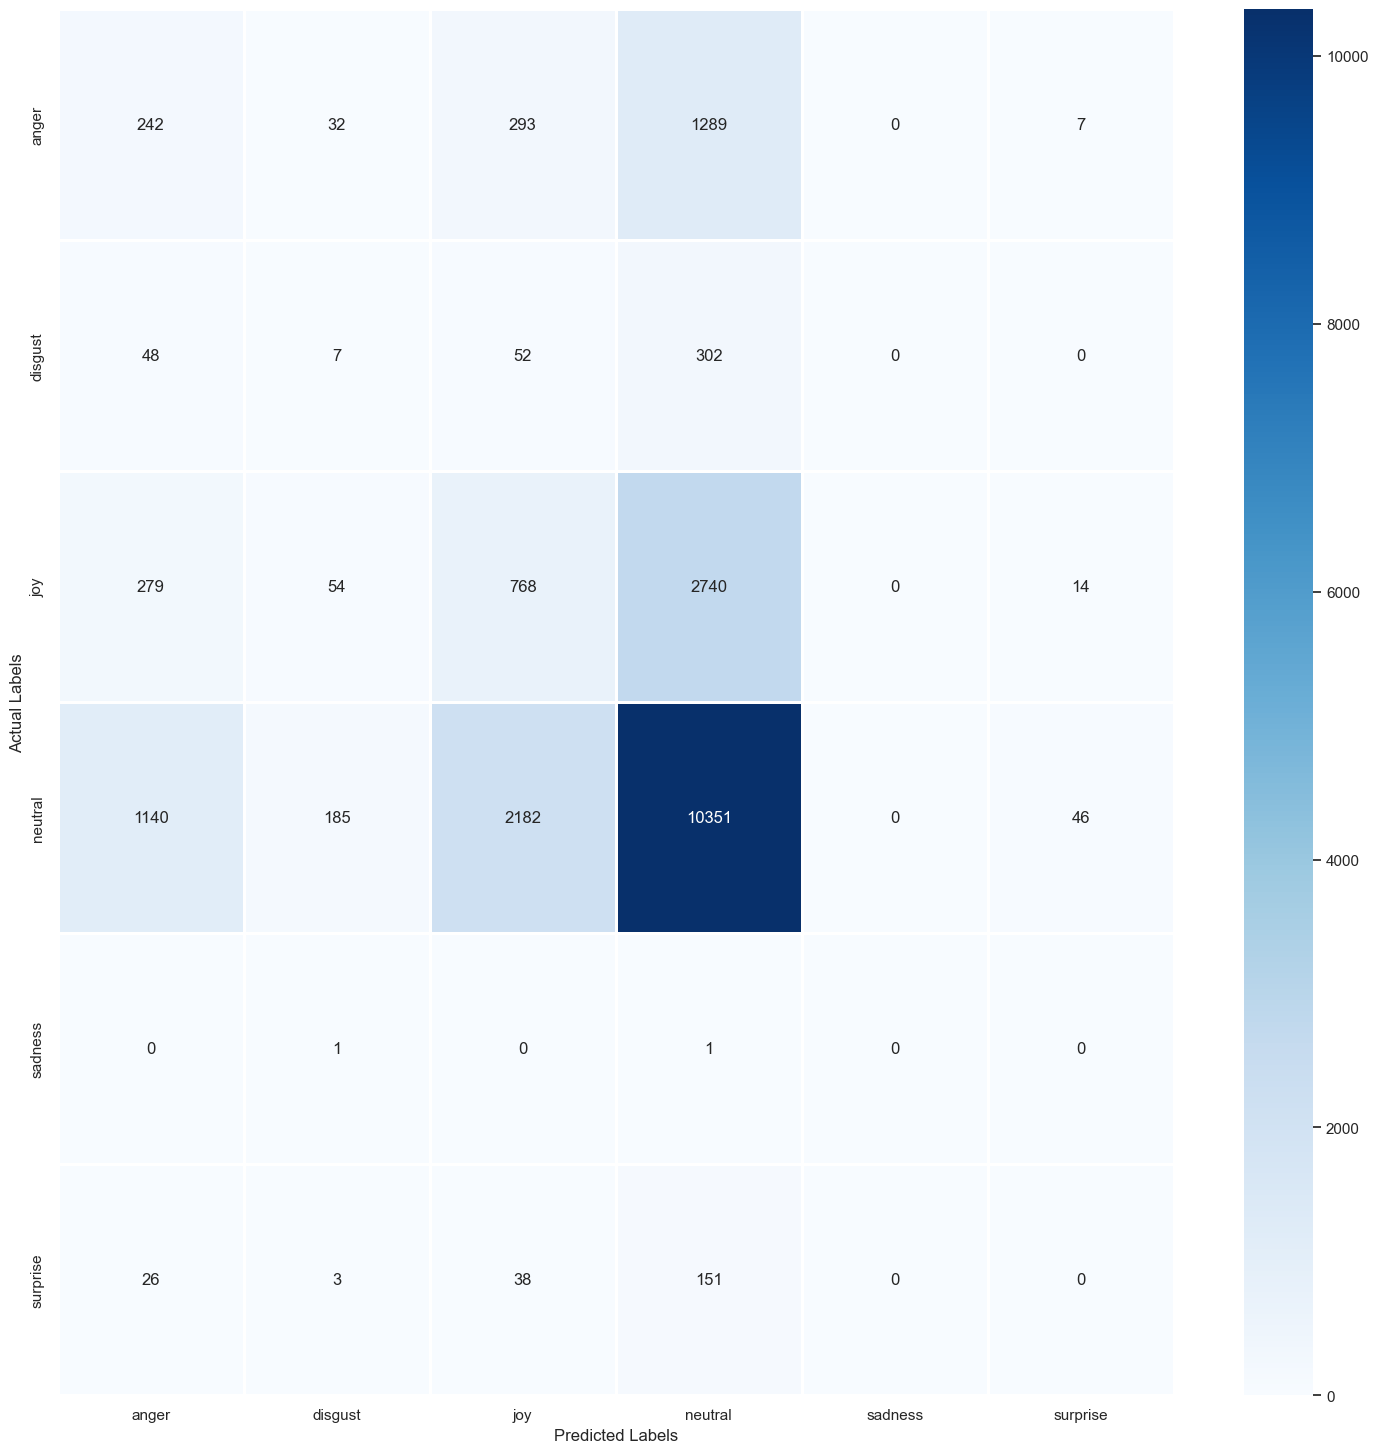

In [110]:
from sklearn.metrics import confusion_matrix
sns.set_theme(rc={'figure.figsize':(18,18)})
cm = confusion_matrix(asd['Realidad'], asd['Prediccion'])
cm = pd.DataFrame(cm , index = [i for i in ['anger', 'disgust', 'joy', 'neutral', 'sadness', 'surprise']] , columns = [i for i in['anger', 'disgust', 'joy', 'neutral', 'sadness', 'surprise']])
sns_plot = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
sns_plot.set_xlabel("Predicted Labels")
sns_plot.set_ylabel("Actual Labels")
plt.show()